# Подготовка окружения и загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from statistics import mean

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, mean_absolute_percentage_error

from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv

try:
    import optuna
except Exception:
    ! pip install optuna
    import optuna
    
try:
    import shap
except Exception:
    ! pip install shap
    import shap
    
pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv('df_engineering_new2.csv')

In [3]:
df.head()

,Цена,Количество_комнат,Общая_площадь,Этаж,Ремонт,Отделка,Способ_продажи,Тип_дома,Пассажирский_лифт,Грузовой_лифт,Тип_участия,Широта_Объекта,Долгота_Объекта,комендантский проспект_dist,крестовский остров_dist,шушары_dist,парнас_dist,купчино_dist,улица дыбенко_dist,девяткино_dist,проспект ветеранов_dist,Цена_кв_м,Цена_кв_м_кат,Балкон_или_лоджия_свертка,Вид_сделки_свертка,В_доме_свертка,Двор_свертка,Мебель_свертка,Окна_свертка,Парковка_свертка,Санузел_свертка,Техника_свертка,Тип_комнат_свертка,Возраст_дома,Грузовой_лифт_no_info,Пассажирский_лифт_no_info
0,9800000,3,73.0,1,косметический,no_info,свободная,кирпичный,0,0,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10,1,1
1,24000000,3,85.0,3,дизайнерский,no_info,свободная,кирпичный,0,0,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3,0,0,0,1,0,2,1,1,0,1,0,1,1
2,12500000,2,55.0,8,требует ремонта,no_info,альтернативная,панельный,2,0,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2,1,0,1,0,1,1,1,1,0,1,30,0,0
3,14200000,1,50.0,17,требует ремонта,no_info,альтернативная,монолитный,1,1,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3,1,0,1,2,0,0,2,1,0,0,13,0,0
4,5500000,0,26.0,9,косметический,no_info,свободная,монолитный,0,0,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2,1,1,1,2,3,2,1,1,2,0,14,1,1


In [4]:
df.columns = [
    'cost',
    'rooms',
    'total_area',
    'stage',
    'repair',
    'decoration',
    'sale_method',
    'building_type',
    'elevator',
    'largage_elevator',
    'participation_type',
    'latitude',
    'longitude',
    'komendatskiy_prospekt_dist',
    'krestovskiy_ostrov_dist',
    'shushary_dist',
    'parnas_dist',
    'kupchino_dist',
    'ulitsa_dybenko_dist',
    'devyatkino_dist',
    'prospekt_veteranov_dist',
    'cost_m_2',
    'Цена_кв_м_кат',
    'balcony',
    'deal_type',
    'into_building',
    'yard',
    'furniture',
    'windows',
    'parking',
    'wc',
    'devices',
    'rooms_type',
    'building_age',
    'largage_elevator_no_info',
    'elevator_no_info',
]

In [5]:
df.head()

,cost,rooms,total_area,stage,repair,decoration,sale_method,building_type,elevator,largage_elevator,participation_type,latitude,longitude,komendatskiy_prospekt_dist,krestovskiy_ostrov_dist,shushary_dist,parnas_dist,kupchino_dist,ulitsa_dybenko_dist,devyatkino_dist,prospekt_veteranov_dist,cost_m_2,Цена_кв_м_кат,balcony,deal_type,into_building,yard,furniture,windows,parking,wc,devices,rooms_type,building_age,largage_elevator_no_info,elevator_no_info
0,9800000,3,73.0,1,косметический,no_info,свободная,кирпичный,0,0,no_info,59.737926,30.461476,37.586,34.347,9.662,39.223,13.966,18.991,34.761,26.140,134246.575342,0,1,0,0,1,0,3,0,1,0,1,10,1,1
1,24000000,3,85.0,3,дизайнерский,no_info,свободная,кирпичный,0,0,no_info,59.939086,30.343213,12.163,9.996,16.558,14.252,12.672,15.962,16.599,14.903,282352.941176,3,0,0,0,1,0,2,1,1,0,1,0,1,1
2,12500000,2,55.0,8,требует ремонта,no_info,альтернативная,панельный,2,0,no_info,60.005504,30.254046,0.617,3.791,28.624,11.195,23.751,27.712,21.582,18.162,227272.727273,2,1,0,1,0,1,1,1,1,0,1,30,0,0
3,14200000,1,50.0,17,требует ремонта,no_info,альтернативная,монолитный,1,1,no_info,59.935831,30.249087,8.156,4.162,24.129,17.354,18.354,26.220,25.022,10.417,284000.000000,3,1,0,1,2,0,0,2,1,0,0,13,0,0
4,5500000,0,26.0,9,косметический,no_info,свободная,монолитный,0,0,no_info,59.838028,30.352169,21.616,18.091,9.174,25.526,2.771,16.488,25.649,11.298,211538.461538,2,1,1,1,2,3,2,1,1,2,0,14,1,1


# Baseline - Human learning

В качестве baseline выбрана модель, которая предсказывает среднюю стоимость квадратного метра в группе со схожими значениями общей площади.

В качестве метрики будем использовать MAPE, которая показывает среднее в процентах отклонение предсказанного значения от истинного.

Здесь и далее используется 80% датасета для обучения и 20% для проверки его качества. 

In [6]:
SEED = 26

In [7]:
train, test = train_test_split(df, test_size=.2, random_state=SEED)

y = ['cost_m_2']

square_categories = [0, 30, 40, 50, 60, 70, float('inf')]
square_labels = list(range(len(square_categories) - 1))

train['total_area_cat'] = pd.cut(train['total_area'], square_categories, labels=square_labels)
test['total_area_cat'] = pd.cut(test['total_area'], square_categories, labels=square_labels)

In [8]:
values = []
state = np.random.RandomState(SEED)

for i in range(1000):
    df_sample_test = train.sample(frac=0.2, replace=True, random_state=state)
    df_sample_train = train.drop(df_sample_test.index)
    learning_mask = df_sample_train.groupby(by='total_area_cat')[y].agg('median').reset_index()
    df_sample_test = df_sample_test.merge(learning_mask, how='left', on='total_area_cat', suffixes=('', '_pred_hl'))
    values.append(mean_absolute_percentage_error(df_sample_test['cost_m_2'], df_sample_test['cost_m_2_pred_hl']))

In [9]:
baseline = mean(values)
baseline

0.23244921404121371

Предложенный baseline ошибается на 23,2%. 
Для определенных задач этого может быть достаточно, но попробуем уменшить значение.

# CatBoost

Моделирование проведем в следующей последовательности:
- кодирование признаков;
- обучение ненастроенной модели CatBoost, проверка качества обучения при помощи кроссвалидации;
- настройка гиперпараметров при помощи Optuna с использованием кроссвалидации;
- анализ важности признаков и исключение наименее важных для моделирования;
- обучение модели на полной обучающей выборке и проверка качества на тестовой.

## Кодирвание признаков

In [10]:
def ohe_transformer(df, cat_features, encoder, encoder_columns):
    ohe = encoder.transform(df[cat_features])
    ohe = pd.DataFrame(ohe, columns=encoder_columns, index=df.index)
    ohe = df.drop(cat_features, axis=1).join(ohe)#.astype('int')
    return ohe

In [11]:
def ohe(train, test, cat_features):
    encoder = OneHotEncoder(drop="first", sparse=False)
    encoder.fit(train[cat_features])
    encoder_columns = ["_".join(x.split()) for x in encoder.get_feature_names_out()]
    return ohe_transformer(
        train, cat_features, encoder, encoder_columns
    ), ohe_transformer(test, cat_features, encoder, encoder_columns), encoder_columns

In [12]:
X = df.drop(y + ['cost', 'Цена_кв_м_кат'], axis=1).columns.tolist() + ['total_area_cat']

cat_features = [
    'repair',
    'decoration',
    'sale_method',
    'building_type',
    'participation_type',
    'total_area_cat',
]

## Обучение ненастроенной модели

In [13]:
pool_train = Pool(
    train[X], 
    train[y],
    cat_features=cat_features
    )

In [14]:
%%time

params = {
    "learning_rate": 0.8,
    "eval_metric": "MAPE",
    "loss_function": "MAPE",
    "random_seed": SEED,
    "early_stopping_rounds": 200,
}

cv_untuned = cv(
    pool=pool_train,
    params=params,
    fold_count=5,
    shuffle=True,
    verbose=250,
    return_models=True,
)

Training on fold [0/5]
0:	learn: 0.2676652	test: 0.2642185	best: 0.2642185 (0)	total: 252ms	remaining: 4m 11s
250:	learn: 0.2195291	test: 0.2235715	best: 0.2235715 (250)	total: 11s	remaining: 32.8s
500:	learn: 0.2159831	test: 0.2213608	best: 0.2213374 (486)	total: 22.3s	remaining: 22.2s
750:	learn: 0.2136601	test: 0.2199616	best: 0.2199616 (748)	total: 34.2s	remaining: 11.3s
999:	learn: 0.2126119	test: 0.2198959	best: 0.2198684 (955)	total: 45.7s	remaining: 0us

bestTest = 0.2198684228
bestIteration = 955

Training on fold [1/5]
0:	learn: 0.2670616	test: 0.2621632	best: 0.2621632 (0)	total: 56ms	remaining: 55.9s
250:	learn: 0.2189693	test: 0.2228611	best: 0.2228611 (250)	total: 12.5s	remaining: 37.2s
500:	learn: 0.2162743	test: 0.2217977	best: 0.2217977 (500)	total: 23.6s	remaining: 23.5s
750:	learn: 0.2127803	test: 0.2196550	best: 0.2196226 (713)	total: 34s	remaining: 11.3s
999:	learn: 0.2108051	test: 0.2181379	best: 0.2181154 (944)	total: 44.4s	remaining: 0us

bestTest = 0.2181154048

In [15]:
cv_untuned[0]['test-MAPE-mean'].min(), cv_untuned[0]['test-MAPE-std'].min()

(0.2243057792500835, 0.003721466940346487)

In [16]:
baseline - cv_untuned[0]['test-MAPE-mean'].min()

0.008143434791130222

Получено улучшение относительно baseline менее, чем на 1%.
Это говорит о сильной зашумленности данных, которая может быть частично нивелирована за счет настройки гиперпараметров.

## Настройка гиперпараметров

In [17]:
def objective_cb(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

In [18]:
%%time
study_cb = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb.optimize(objective_cb, n_trials=20, show_progress_bar=True)

[I 2023-01-07 13:33:01,214] A new study created in memory with name: no-name-ef7e706c-a945-4769-98fb-f006e5f7b0a3
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.2137117066
bestIteration = 997

Training on fold [1/5]

bestTest = 0.205598551
bestIteration = 952

Training on fold [2/5]

bestTest = 0.211770337
bestIteration = 983

Training on fold [3/5]

bestTest = 0.2269911826
bestIteration = 999

Training on fold [4/5]

bestTest = 0.2180127005
bestIteration = 967

[I 2023-01-07 13:38:04,361] Trial 0 finished with value: 0.21536250079557123 and parameters: {'learning_rate': 0.37714145736247373, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.07914678953841761, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.21536250079557123.
Training on fold [0/5]

bestTest = 0.2837391867
bestIteration = 969

Training on fold [1/5]

bestTest = 0.2734752029
bestIteration = 970

Training on fold [2/5]

bestTest = 0.2893988512
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2741040223
bestIteration = 997

Training on fold [4/5]

bestTest = 0.2919721905
bestIteration = 999


In [19]:
baseline - study_cb.best_trial.value

0.04795384576525061

Получено улучшение относительно baseline на 5,6%. 

Trial 13 finished with value: 0.17730214147198814 and parameters: {'learning_rate': 0.9908686688288321, 'min_data_in_leaf': 10, 'colsample_bylevel': 0.07076944829054156, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 13 with value: 0.17730214147198814.

## Анализ важности признаков

In [20]:
best_params = study_cb.best_params

In [21]:
params_tuned = {
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "used_ram_limit": "8gb",
        **best_params
    }

cb_tuned = CatBoostRegressor(**params_tuned, verbose=250)

In [22]:
cb_tuned.fit(pool_train)

0:	learn: 0.2281359	total: 4.4ms	remaining: 4.39s
250:	learn: 0.0987767	total: 8.03s	remaining: 23.9s
500:	learn: 0.0776005	total: 15.9s	remaining: 15.8s
750:	learn: 0.0673664	total: 23.7s	remaining: 7.87s
999:	learn: 0.0574583	total: 31.8s	remaining: 0us


In [23]:
feature_important = pd.DataFrame(
    cb_tuned.feature_importances_, 
    cb_tuned.feature_names_,
    columns=['value']).sort_values(by='value', ascending=False)

feature_important

,value
repair,5.816576
building_type,5.492255
decoration,5.317267
total_area_cat,5.213599
total_area,5.137867
krestovskiy_ostrov_dist,4.644383
ulitsa_dybenko_dist,4.488022
rooms,4.318583
kupchino_dist,3.572637
participation_type,3.470872


In [24]:
def shap_plot(model, train):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(train)
    shap.summary_plot(shap_values, train, plot_size=(15, 8))

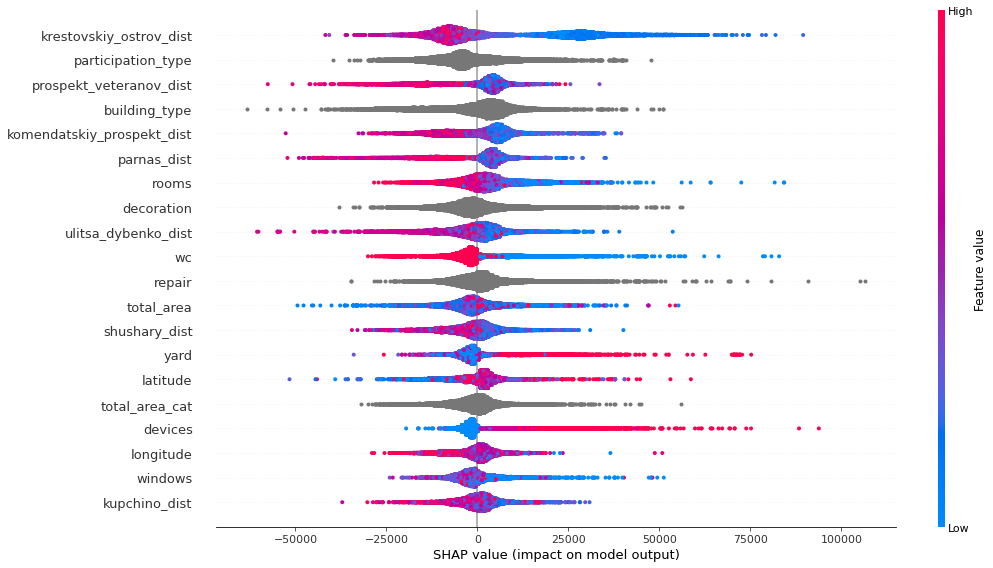

In [25]:
shap_plot(cb_tuned, train[X])

Империческим методом получено, что следующие признаки оказывают наибольшее влияние на качество работы модели.

In [34]:
X_crutial = [
    'rooms',
    'total_area',
    'stage',
    'latitude',
    'longitude',
    'komendatskiy_prospekt_dist',
    'krestovskiy_ostrov_dist',
    'shushary_dist',
    'parnas_dist',
    'kupchino_dist',
    'ulitsa_dybenko_dist',
    'devyatkino_dist',
    'prospekt_veteranov_dist',
    'balcony',
    'building_age',
    'largage_elevator',
    'elevator',
    ]

cat_features_crutial = [x for x in cat_features if x in X_crutial]

## Проверка качества модели на тестовой подвыборке

In [35]:
pool_train_crutial = Pool(
    train[X_crutial], 
    train[y],
    cat_features=cat_features_crutial
    )

pool_test = Pool(
    test[X_crutial], 
    test[y],
    cat_features=cat_features_crutial
    )

In [47]:
def objective_cb_fin(trial):

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.7),
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "8gb",
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cv_optuna = cv(
            pool=pool_train_crutial,
            params=params,
            fold_count=5,
            shuffle=True,
            verbose=False,
            return_models=True,
            )
    
    return cv_optuna[0]['test-MAPE-mean'].min()

study_cb_fin = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=SEED))
study_cb_fin.optimize(objective_cb_fin, n_trials=20, show_progress_bar=True)

[I 2023-01-07 23:44:55,700] A new study created in memory with name: no-name-7f561eba-23b6-47e5-b1c1-12140f503fd5
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

Training on fold [0/5]

bestTest = 0.2562561173
bestIteration = 980

Training on fold [1/5]

bestTest = 0.2509768263
bestIteration = 999

Training on fold [2/5]

bestTest = 0.2535710677
bestIteration = 999

Training on fold [3/5]

bestTest = 0.2507238334
bestIteration = 982

Training on fold [4/5]

bestTest = 0.242037839
bestIteration = 983

[I 2023-01-07 23:45:53,854] Trial 0 finished with value: 0.2507144514994022 and parameters: {'learning_rate': 0.2847609715749825, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.07914678953841761, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.2507144514994022.
Training on fold [0/5]

bestTest = 0.3204284356
bestIteration = 974

Training on fold [1/5]

bestTest = 0.3082555613
bestIteration = 999

Training on fold [2/5]

bestTest = 0.3183921036
bestIteration = 999

Training on fold [3/5]

bestTest = 0.311170367
bestIteration = 982

Training on fold [4/5]

bestTest = 0.3125613665
bestIteration = 999

[I

In [48]:
baseline - study_cb_fin.best_trial.value

0.053822102826247525

In [49]:
study_cb_fin.best_params

{'learning_rate': 0.47995824961714395,
 'min_data_in_leaf': 4,
 'colsample_bylevel': 0.09781525853636924,
 'depth': 10,
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 6.401737432094735}

In [50]:
best_params_fin = study_cb_fin.best_params
#best_params_fin = {'learning_rate': 0.669937374425716, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.09781525853636924, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.401737432094735}

In [51]:
params_fin = {
        "eval_metric": "MAPE",
        "loss_function": "MAPE",
        "random_seed": SEED,
        "early_stopping_rounds": 200,
        "used_ram_limit": "8gb",
        **best_params_fin
    }

cb_fin = CatBoostRegressor(**params_fin, verbose=250)
cb_fin.fit(pool_train_crutial)

0:	learn: 0.2281505	total: 2.39ms	remaining: 2.39s
250:	learn: 0.1617645	total: 1.41s	remaining: 4.22s
500:	learn: 0.1482511	total: 2.74s	remaining: 2.73s
750:	learn: 0.1412510	total: 4.02s	remaining: 1.33s
999:	learn: 0.1362332	total: 5.46s	remaining: 0us


In [52]:
test['y_pred_cb'] = cb_fin.predict(pool_test)

mean_absolute_percentage_error(test[y], test['y_pred_cb'])

0.16170973714517026

In [53]:
cb_fin.save_model('catboost_model.json')
cb_fin.save_model('catboost_model.cbm')

# Заключение

Проведено моделирование с использованием инструментов CatBoost, в ходе которого настроены гиперпараметры и используемые признаки.
Получена модель, ошибка предсказания которой не превосходит 16,17%.
Указанное значение почти на 5% меньше ошибки предсказания "вручную", используя категоризацию по значению общей площади.